# Notebook 2: Data Cleaning and Feature Engineering

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. Text Sentiment feature creation
2. Weighted Review Score feature creation
3. Final feature removal
4. Imputation strategy

**Note: Some Cleaning and Engineering Steps Already Performed in Notebook 1: Data Exploration**
1. Dropped "source" column.
2. Removed duplicates keeping, most recent (date) observation.
3. Removed uneeded columns such as pictures, host id's, etc. 
4. Filled missing values for bathrooms.
5. Added zipcodes for neighborhood categories.
7. Removed one feature from feature pairs with a correlation over 0.75.
6. Created a binary variable based on property type descriptions.
7. Created a binary variable based on if a property is private or shared with host.

In [2]:
# Library Imports
import pandas as pd
import numpy as np

# Note needed to install older version 4.28.0
from transformers import pipeline

In [10]:
# Import data from last notebook
eda_df = pd.read_csv("../Data/eda.csv.gz", compression = "gzip")
eda_df.head(1)

,name,description,neighborhood_overview,host_listings_count,latitude,longitude,property_type,room_type,bathrooms,bedrooms,...,review_scores_rating,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode,median_income_dollars,property_type_binary,private
0,Huge Oceanview decks+RooftopDeck☀sleeps 10☀Gar...,10 steps from the boardwalk! Beautiful beach h...,NaN,52.0,32.78568,-117.25271,Entire home,Entire home/apt,2.0,2.0,...,4.84,t,30,0,0,3.77,92109,95170.0,house,1


## Sentiment Based Feature Creation
In order to capture the sentiment from our text-based variables, we will use transfer learning with a pre-trained model.

First we'll combine all of our text-based columns into one.

In [11]:
# In order to combine, we need to fill any NAs with blank strings
eda_df[['name', 'description', 'neighborhood_overview']] = eda_df[['name', 'description', 'neighborhood_overview']].fillna('')

# Combine
eda_df['text'] = eda_df['name'] + eda_df['description']
eda_df['text'] = eda_df['text'] + eda_df['neighborhood_overview']

# Our model can only handle less than 512 tokens so we'll truncate down
eda_df['text_trunc'] = eda_df['text'].str.slice(0, 511)

# How many observations were affected - Looks like none, but still got an error - could be due to different tokenzations
eda_df['word_counts'] = eda_df['text'].apply(lambda n : len(n.split())) 
len(eda_df[eda_df['word_counts'] < 511])

# Save our observations as a list
corpus = eda_df['text_trunc'].to_list()


In [12]:
# Load our model
sent_clf = pipeline('sentiment-analysis')

preds = []
for i in corpus:
    try:
        pred = sent_clf(i)
        preds.append(pred)
    except:
        preds.append(np.nan)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [13]:
# Un-nest the list
import operator 
from functools import reduce

preds2 = reduce(operator.add, preds)

# Create probability of positive as our variable
probs = [x['score'] if x['label'].startswith('P') else 1 - x['score'] for x in preds2]

# Save as variable in our df
eda_df['sentiment'] = probs

In [14]:
# Write new df so we don't need to rerun model everytime
eda_df.to_csv("../Data/sentiment.csv.gz", compression= "gzip", index=False)

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## Review Feature Creation

We did some further exploration on reviews since we believed that they were an important part of the process. We discovered that creating a weighted review score by multiplying the number of reviews and review score rating variable led to a high correlation with price.

In [3]:
# Read back in the data with sentiments
sent_df = pd.read_csv("../Data/sentiment.csv.gz", compression = "gzip")
sent_df.head(1)

,name,description,neighborhood_overview,host_listings_count,latitude,longitude,property_type,room_type,bathrooms,bedrooms,...,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode,median_income_dollars,property_type_binary,private,text,text_trunc,word_counts,sentiment
0,Huge Oceanview decks+RooftopDeck☀sleeps 10☀Gar...,10 steps from the boardwalk! Beautiful beach h...,NaN,52.0,32.78568,-117.25271,Entire home,Entire home/apt,2.0,2.0,...,0,3.77,92109,95170.0,house,1,Huge Oceanview decks+RooftopDeck☀sleeps 10☀Gar...,Huge Oceanview decks+RooftopDeck☀sleeps 10☀Gar...,171,0.900577


Text(0, 0.5, 'Price')

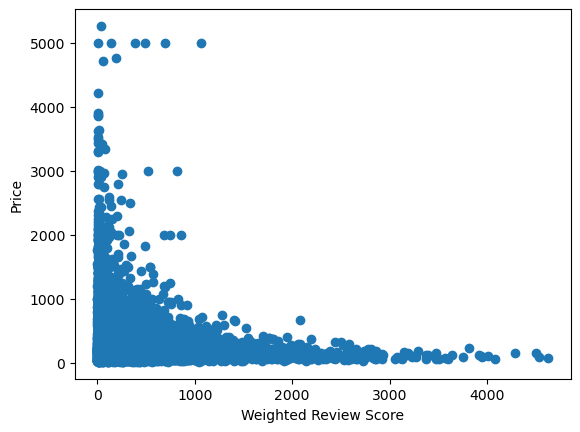

In [4]:
import matplotlib.pyplot as plt

# Remove the large outlierS
sent_df = sent_df[sent_df['price'] < 8000]
sent_df['review_score_weighted'] = sent_df['review_scores_rating'] * sent_df['number_of_reviews']
plt.plot('review_score_weighted', 'price', data=sent_df, marker = 'o', linestyle = 'none')
plt.xlabel('Weighted Review Score')
plt.ylabel('Price')

## Feature Removal

We do not need the text based features that were originally in the data as well as the ones we created, since they are being replaced by the sentiment variable. The same goes for our review features being replaced by the weighted review score. Finally, we will remove the latitude and longitude. As we discussed in the EDA notebook, they have a very low variance, and are being replaced by the categorical zipcode variable.

In [5]:
# Remove the text columns
sent_df = sent_df.drop(columns = [
    'name', 'description', 'neighborhood_overview',
    'text', 'text_trunc', 'word_counts']
    )

# Remove the review score columns
sent_df = sent_df.drop(columns=[
    'review_scores_rating', 'number_of_reviews'
])

# Remove low variance features 
sent_df = sent_df.drop(columns=['longitude', 'latitude'])


## Data Types
Let's make sure all the columns are the correct data type 

In [6]:
sent_df.dtypes

host_listings_count                             float64
property_type                                    object
room_type                                        object
bathrooms                                       float64
bedrooms                                        float64
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          float64
maximum_maximum_nights                          float64
has_availability                                 object
availability_30                                   int64
availability_365                                  int64
instant_bookable                                 object
calculated_host_listings_count                    int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               

In [7]:
# Zipcode is categorical not numeric so we'll change it to an object
sent_df['zipcode'] = sent_df['zipcode'].astype(object)

In [8]:
# Read out clean df
sent_df.to_csv("../Data/clean_df.csv.gz", compression= "gzip", index=False)

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


## Imputation Strategy
Currently most of our missing data is coming from review related features. To prevent losing any observations to train on, we will impute any missing numeric features with the median of that column for the training dataset. Imputation will be handled in the modeling pipeline to prevent any spillover from training to testing datasets. No categorical feature had missing data, so we will not need to worry about imputation for those features.

In [9]:
# Read in the csv file from the previous notebook
preproc_df = pd.read_csv("../Data/clean_df.csv.gz",
                         compression = "gzip")

preproc_df.head(1)

,host_listings_count,property_type,room_type,bathrooms,bedrooms,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_maximum_nights,...,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode,median_income_dollars,property_type_binary,private,sentiment,review_score_weighted
0,52.0,Entire home,Entire home/apt,2.0,2.0,728.0,2,28,1.0,1125.0,...,30,0,0,3.77,92109,95170.0,house,1,0.900577,150.04


In [10]:
preproc_df.isna().sum()

host_listings_count                               51
property_type                                      0
room_type                                          0
bathrooms                                          0
bedrooms                                        1534
price                                              0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             2
maximum_maximum_nights                             2
has_availability                                   0
availability_30                                    0
availability_365                                   0
instant_bookable                                   0
calculated_host_listings_count                     0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               3180
zipcode                                       

### Resolving Missing Values in _bedrooms_

In [11]:
# First, assess the types of listings missing records bedrooms
preproc_df[preproc_df["bedrooms"].isnull()]["property_type"].value_counts()

property_type
Entire rental unit             641
Entire guesthouse              190
Entire condo                   174
Entire guest suite             136
Entire serviced apartment      102
Entire home                     72
Entire loft                     44
Camper/RV                       23
Entire cottage                  19
Private room in rental unit     18
Entire bungalow                 17
Tiny home                       15
Private room in home            12
Room in boutique hotel          11
Private room in resort          10
Entire vacation home             9
Room in hotel                    8
Private room in guest suite      6
Private room in guesthouse       4
Private room in condo            3
Private room in camper/rv        3
Private room in hostel           2
Entire place                     2
Barn                             2
Private room in bungalow         1
Private room in cottage          1
Private room in loft             1
Casa particular                  1
Entire

It can be reasonably assumed that property type values with "room" or "RV" are a have a single bedroom. So the missing values can be filled with the value of 1.

In [12]:
# Fill bedrooms with a value of 1 for those that are listed as rooms
# Indexes of records with the word "room" or RV in the property_type
room_idx = preproc_df[
    preproc_df["property_type"].astype(str).str.contains("|".join(["room", "Room", "RV"]))
    ].index.tolist()

preproc_df.loc[room_idx, "bedrooms"] = preproc_df.loc[room_idx, "bedrooms"].fillna(1)

Typically, the number of bedrooms and bathrooms are fairly similar. Thus, the unique number of bedroom-bathroom combinations will be examined. The number of bedrooms will be filled based on the number of bathrooms.

In [13]:
# Look at all unique bedroom-bathroom combinations in the dataset
bed_bath_df = preproc_df.groupby(["bathrooms", "bedrooms"]).size().reset_index().rename(columns={0:"count"})

# Look at listings that have one bathroom, to assess the most common number of bedrooms
bed_bath_df[bed_bath_df["bathrooms"] == 1]

,bathrooms,bedrooms,count
5,1.0,1.0,7491
6,1.0,2.0,2305
7,1.0,3.0,354
8,1.0,4.0,14
9,1.0,5.0,3
10,1.0,6.0,1
11,1.0,7.0,1
12,1.0,9.0,1
13,1.0,11.0,1
14,1.0,12.0,3


In [14]:
# Look at all listings with 0 bathrooms
bed_bath_df[bed_bath_df["bathrooms"] == 0]

,bathrooms,bedrooms,count
0,0.0,1.0,46
1,0.0,2.0,5
2,0.0,3.0,1
3,0.0,9.0,1


Based on the above, if a listing has zero or one bathroom, it most likely also only has one bedroom. Therefore, if a listing has zero or one bathroom, the value for bedroom will be filled with 1.

In [15]:
# Fill bedrooms with a value of 1 for 1 bathroom
# Indexes of records with 1 bathrooms
bathroom_1_idx = preproc_df.loc[
    preproc_df["bathrooms"].isin([0,1])
    ].index.tolist()

preproc_df.loc[bathroom_1_idx, "bedrooms"] = preproc_df.loc[bathroom_1_idx, "bedrooms"].fillna(1)

In [16]:
# Check for remaining missing bedroom values
preproc_df[preproc_df["bedrooms"].isnull()]

,host_listings_count,property_type,room_type,bathrooms,bedrooms,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_maximum_nights,...,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode,median_income_dollars,property_type_binary,private,sentiment,review_score_weighted
11636,0.0,Entire home,Entire home/apt,2.0,NaN,499.0,2,999,2.0,1125.0,...,15,4,0,NaN,92126,105284.0,house,1,0.999438,NaN
11637,0.0,Entire home,Entire home/apt,2.0,NaN,499.0,2,365,2.0,1125.0,...,15,4,0,0.20,92126,105284.0,house,1,0.999400,8.00
13761,29.0,Entire home,Entire home/apt,6.0,NaN,1175.0,2,21,2.0,21.0,...,26,0,0,NaN,92104,79929.0,house,1,0.994432,NaN
14467,7.0,Tiny home,Entire home/apt,2.0,NaN,99.0,1,1125,1.0,1125.0,...,7,5,0,5.39,92122,88073.0,house,0,0.573923,528.64
16212,191.0,Entire home,Entire home/apt,2.0,NaN,151.0,30,1125,30.0,1125.0,...,9,0,0,0.85,91910,77005.0,house,1,0.999634,136.01


In [17]:
# The three of the records were filled by manually looking up the homes using the url provided in the original data
preproc_df.loc[11666, "bedrooms"] = 1 
preproc_df.loc[11667, "bedrooms"] = 2 
preproc_df.loc[13799, "bedrooms"] = 2
preproc_df.loc[14509, "bedrooms"] = 2 # A tiny home logically cannot have more than 2 bedrooms
preproc_df.loc[16290, "bedrooms"] = 2 # Most 2 bathroom places have 2 bedrooms in the data

In [18]:
# Check if any missing values are left
preproc_df[preproc_df["bedrooms"].isnull()].shape

# 0 rows - all missing values have been filled

(5, 24)

### Dropping Rows with Missing Values
There are 51 missing values in _host_listings_count_, 2 in _minimum_minimum_nights_, and 2 in _maximum_minimum_nights_. As these values cannot be imputed, it was deemed acceptable to drop up to 55 records, since the data set contains over 18,000 records.

In [19]:
# Drop rows with missing values in the following columns
preproc_df.dropna(
    subset = ["host_listings_count", "minimum_minimum_nights", "maximum_maximum_nights"],
    inplace = True)

### Imputing Zero for Missing Values in _reviews_per_month_ and _review_score_weighted_

In [20]:
preproc_df["reviews_per_month"].fillna(0, inplace = True)
preproc_df["review_score_weighted"].fillna(0, inplace = True)

In [21]:
# Export imputed dataframe
preproc_df.to_csv("../Data/model_ready.csv.gz", compression = "gzip", index = False)

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\pandas\core\internals\blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)
